In [1]:
import torch, os, torchvision, shutil, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [21]:
SRC_DS_PATH = "dataset"
TGT_DS_PATH = "datasets"

label_idx = {"AKIEC": 1, "BCC": 2, "BKL": 3, "DF": 4, "MEL": 5, "NV": 6, "VASC": 7}
idx_label = {v: k for k, v in label_idx.items()}

In [ ]:
url = "https://github.com/ProAltro/DL-Project/"
os.system(f"git clone {url}")

In [30]:
if TGT_DS_PATH not in os.listdir():
    os.mkdir(TGT_DS_PATH)


def process_images(ds_type):
  if ds_type not in os.listdir(TGT_DS_PATH):
      os.mkdir(f"{TGT_DS_PATH}/{ds_type}")

  for file in os.listdir(f"{SRC_DS_PATH}/{ds_type}"):
    cl, _, num = file.split("_")
    cl = idx_label[int(cl)]
    if cl not in os.listdir(f"{TGT_DS_PATH}/{ds_type}"):
      os.mkdir(f"{TGT_DS_PATH}/{ds_type}/{cl}")

    shutil.copy(f"./{SRC_DS_PATH}/{ds_type}/{file}", f"{TGT_DS_PATH}/{ds_type}/{cl}/{num}")


process_images("train")
process_images("val")

train_num = {}
val_num = {}
for cl in os.listdir(f"{TGT_DS_PATH}/train"):
    train_num[cl] = len(os.listdir(f"{TGT_DS_PATH}/train/{cl}"))
    val_num[cl] = len(os.listdir(f"{TGT_DS_PATH}/val/{cl}"))

In [31]:
target_num = int(max(train_num.values())*0.5)

for cl in os.listdir(f"{TGT_DS_PATH}/train"):
    if len(os.listdir(f"{TGT_DS_PATH}/train/{cl}")) >= target_num:
        files = os.listdir(f"{TGT_DS_PATH}/train/{cl}")
        for file in files[target_num:]:
            os.remove(f"{TGT_DS_PATH}/train/{cl}/{file}")
    else:
        files = os.listdir(f"{TGT_DS_PATH}/train/{cl}")
        cur = len(files)
        tgt = max(min(target_num, cur * 2),int(target_num*0.5)) - cur
        max_ind = max(map(lambda x: int(x.split(".")[0]), files))
        for i in range(tgt):
            shutil.copy(
                f"{TGT_DS_PATH}/train/{cl}/{files[i % cur]}",
                f"{TGT_DS_PATH}/train/{cl}/{max_ind+i}.jpg",
            )

In [32]:
train_num = {}
val_num = {}
for cl in os.listdir(f"{TGT_DS_PATH}/train"):
    train_num[cl] = len(os.listdir(f"{TGT_DS_PATH}/train/{cl}"))
    val_num[cl] = len(os.listdir(f"{TGT_DS_PATH}/val/{cl}"))

print(f"Training: {train_num}")
print(f"Validation: {val_num}")
print(sum(train_num.values()) + sum(val_num.values()))

Training: {'AKIEC': 517, 'BCC': 517, 'BKL': 685, 'DF': 517, 'MEL': 517, 'NV': 1036, 'VASC': 517}
Validation: {'AKIEC': 36, 'BCC': 60, 'BKL': 102, 'DF': 15, 'MEL': 97, 'NV': 670, 'VASC': 20}
5306


In [ ]:
train_img = torchvision.datasets.ImageFolder(f"{TGT_DS_PATH}/train", transform=torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        torchvision.transforms.RandomRotation(degrees=15),
        # torchvision.transforms.Normalize(mean=[0.485], std=[0.229]),    
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
    ]
))

val_img = torchvision.datasets.ImageFolder(f"{TGT_DS_PATH}/val", transform=torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
))

train_loader = torch.utils.data.DataLoader(train_img, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_img, batch_size=32, shuffle=True)

## Model 1

In [35]:
# get mobile net v3 large, pretrained
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 7) # 7 classes

# lock the first 10 layers
for param in model.parameters():
    param.requires_grad = False
for i, param in enumerate(model.parameters()):
    if i >= 7:
        param.requires_grad = True

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

weights = [sum(train_num.values())/i for i in train_num.values()]
weights = torch.FloatTensor(weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

C:\Users\prami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
num_epochs = 5
loss_history = []
train_accuracy = []
val_accuracy = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

model = model.to(device)


for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop using default loader
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_history.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    #validation loop to calculate validation accuracy
    #also compute confusion matrix

    y_true = []
    y_pred = []
    total = 0
    correct = 0
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    cm = confusion_matrix(y_true, y_pred, labels=range(7))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy[-1]:.2f}%, Validation Accuracy: {val_accuracy[-1]:.2f}%")
    print("Per class acc:", cm.diagonal()/cm.sum(axis=1))
    print()

Epoch [1/5], Loss: 0.7278, Train Accuracy: 88.96%, Validation Accuracy: 74.50%
Per class acc: [0.47222222 0.73333333 0.52941176 0.26666667 0.49484536 0.84477612
 0.6       ]

Epoch [2/5], Loss: 0.7276, Train Accuracy: 89.20%, Validation Accuracy: 74.90%
Per class acc: [0.44444444 0.75       0.50980392 0.26666667 0.53608247 0.84776119
 0.6       ]

Epoch [3/5], Loss: 0.7312, Train Accuracy: 89.22%, Validation Accuracy: 73.70%
Per class acc: [0.44444444 0.71666667 0.5        0.26666667 0.56701031 0.82985075
 0.6       ]

Epoch [4/5], Loss: 0.7232, Train Accuracy: 89.61%, Validation Accuracy: 74.00%
Per class acc: [0.47222222 0.73333333 0.51960784 0.26666667 0.50515464 0.83731343
 0.6       ]

Epoch [5/5], Loss: 0.7289, Train Accuracy: 89.08%, Validation Accuracy: 74.00%
Per class acc: [0.47222222 0.7        0.50980392 0.26666667 0.54639175 0.8358209
 0.6       ]



In [20]:
name = "mobilenet_v2_weighted_loss"
torch.save(model, f"{name}.pth")
# save the data for the plotting
data = {
    "loss": loss_history,
    "train_accuracy": train_accuracy,
    "val_accuracy": val_accuracy,
}

np.save(f"{name}_data.npy", data)

In [36]:
name = "mobilenet_v2_weighted_loss"
model = torch.load(f"{name}.pth")
model.eval()

data = np.load(f"{name}_data.npy", allow_pickle=True).item()
loss_history, train_accuracy, val_accuracy = data["loss"], data["train_accuracy"], data["val_accuracy"]

C:\Users\prami\AppData\Local\Temp\ipykernel_71916\2779304623.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{name}.pth")


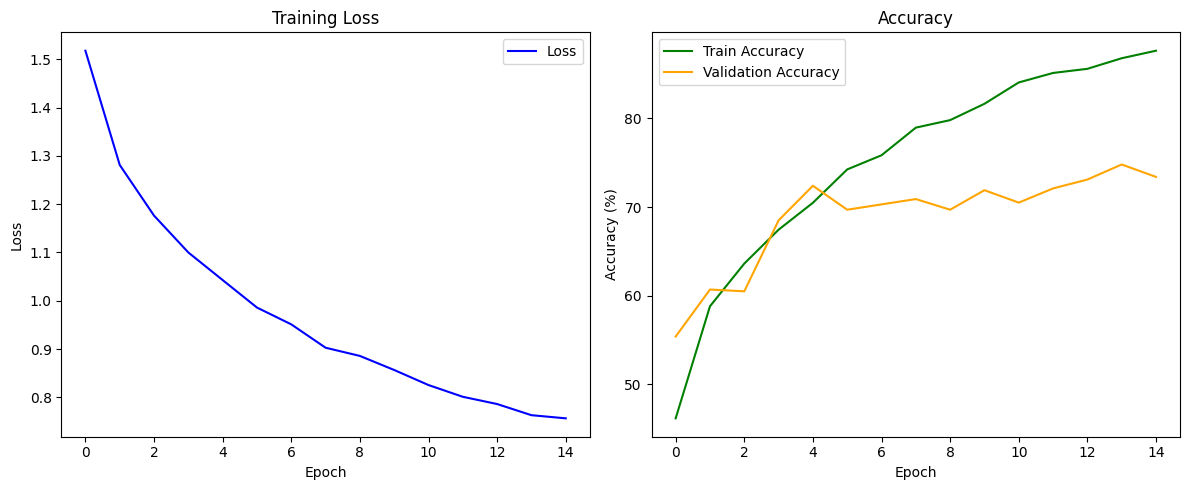

In [29]:
# Plotting the loss and accuracy

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss", color="blue")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy", color="green")
plt.plot(val_accuracy, label="Validation Accuracy", color="orange")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()


plt.savefig("loss_accuracy.png")

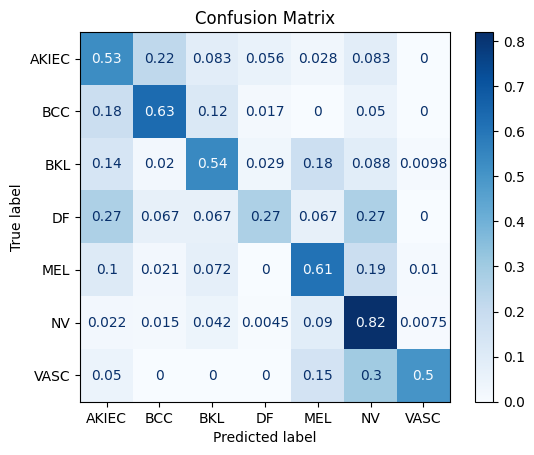

In [30]:
y_true = []
y_pred = []
for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(label_idx.keys())
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

In [34]:
# do accuracy basaed of y_pred and y_true
total_accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) * 100
print(f"Total Accuracy: {total_accuracy:.2f}%")

for i, cl in enumerate(label_idx.keys()):
    class_accuracy = cm[i][i] / np.sum(cm[i]) * 100
    class_precision = cm[i][i] / np.sum(cm[:, i]) * 100
    class_f1 = 2 * (class_accuracy * class_precision) / (class_accuracy + class_precision)


    print(f"{cl} \tAccuracy: {class_accuracy:.2f}% | Precision: {class_precision:.2f}% | F1: {class_f1:.2f}%")


Total Accuracy: 73.40%
AKIEC 	Accuracy: 52.78% | Precision: 40.90% | F1: 46.08%
BCC 	Accuracy: 63.33% | Precision: 64.80% | F1: 64.06%
BKL 	Accuracy: 53.92% | Precision: 58.62% | F1: 56.17%
DF 	Accuracy: 26.67% | Precision: 71.53% | F1: 38.85%
MEL 	Accuracy: 60.82% | Precision: 54.37% | F1: 57.42%
NV 	Accuracy: 81.94% | Precision: 45.69% | F1: 58.67%
VASC 	Accuracy: 50.00% | Precision: 94.77% | F1: 65.46%


## Model 2

In [71]:
# mobile-net v3 large
model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 7) # 7 classes
#change first layer to 1 channel
# model.features[0][0] = torch.nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)

# lock the first 10 layers
for param in model.parameters():
    param.requires_grad = False

for i, param in enumerate(model.parameters()):
    if i >= 10:
        param.requires_grad = True

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
weights = [sum(train_num.values())/i for i in train_num.values()]
weights = torch.FloatTensor(weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

In [72]:
train_img = torchvision.datasets.ImageFolder(
    f"{TGT_DS_PATH}/train",
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            torchvision.transforms.RandomRotation(degrees=15),
            # torchvision.transforms.Normalize(mean=[0.485], std=[0.229]),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
        ]
    ),
)

val_img = torchvision.datasets.ImageFolder(
    f"{TGT_DS_PATH}/val",
    transform=torchvision.transforms.Compose(
        [
            # torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

train_loader = torch.utils.data.DataLoader(train_img, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_img, batch_size=32, shuffle=True)

In [73]:
# Training loop for MobileNetV1
num_epochs = 10
loss_history_v1 = []
train_accuracy_v1 = []
val_accuracy_v1 = []
torch.cuda.empty_cache()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop using default loader
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_history_v1.append(running_loss / len(train_loader))
    train_accuracy_v1.append(100 * correct / total)


    y_true = []
    y_pred = []
    total = 0
    correct = 0
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy_v1.append(100 * correct / total)
    cm = confusion_matrix(y_true, y_pred, labels=range(7))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy_v1[-1]:.2f}%, Validation Accuracy: {val_accuracy_v1[-1]:.2f}%")
    print("Per class acc:", cm.diagonal()/cm.sum(axis=1))
    print()

Epoch [1/10], Loss: 1.3830, Train Accuracy: 52.93%, Validation Accuracy: 66.60%
Per class acc: [0.         0.         0.         0.         0.         0.98656716
 0.25      ]

Epoch [2/10], Loss: 1.1446, Train Accuracy: 66.28%, Validation Accuracy: 58.10%
Per class acc: [0.         0.06666667 0.         0.06666667 0.02061856 0.84179104
 0.5       ]

Epoch [3/10], Loss: 1.0190, Train Accuracy: 72.18%, Validation Accuracy: 63.60%
Per class acc: [0.25       0.26666667 0.03921569 0.2        0.         0.88507463
 0.55      ]

Epoch [4/10], Loss: 0.9212, Train Accuracy: 77.12%, Validation Accuracy: 62.70%
Per class acc: [0.22222222 0.61666667 0.15686275 0.4        0.12371134 0.80447761
 0.45      ]

Epoch [5/10], Loss: 0.8692, Train Accuracy: 80.10%, Validation Accuracy: 66.40%
Per class acc: [0.19444444 0.61666667 0.35294118 0.33333333 0.7628866  0.74477612
 0.3       ]

Epoch [6/10], Loss: 0.8194, Train Accuracy: 82.54%, Validation Accuracy: 56.10%
Per class acc: [0.13888889 0.46666667 0.

In [74]:
name = "mobilenet_v3_large"
torch.save(model, f"{name}.pth")
# save the data for the plotting
data = {
    "loss": loss_history_v1,
    "train_accuracy": train_accuracy_v1,
    "val_accuracy": val_accuracy_v1,
}

np.save(f"{name}_data.npy", data)

In [ ]:
name = "mobilenet_v2_weighted_loss"
model = torch.load(f"{name}.pth")
model.eval()

data = np.load(f"{name}_data.npy", allow_pickle=True).item()
loss_history, train_accuracy, val_accuracy = (
    data["loss"],
    data["train_accuracy"],
    data["val_accuracy"],
)

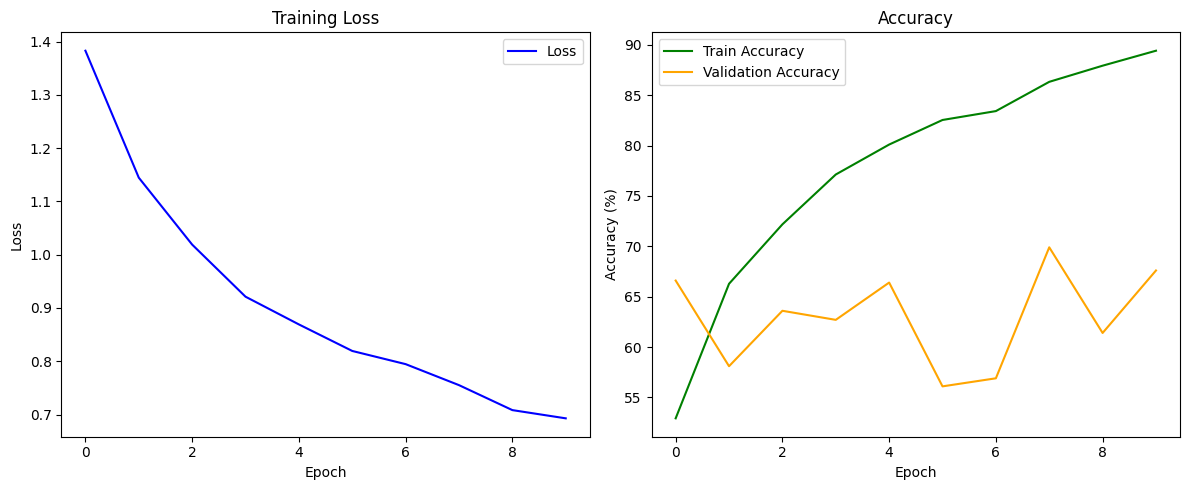

In [75]:
# Plotting the loss and accuracy

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history_v1, label="Loss", color="blue")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_v1, label="Train Accuracy", color="green")
plt.plot(val_accuracy_v1, label="Validation Accuracy", color="orange")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()


plt.savefig("loss_accuracy.png")

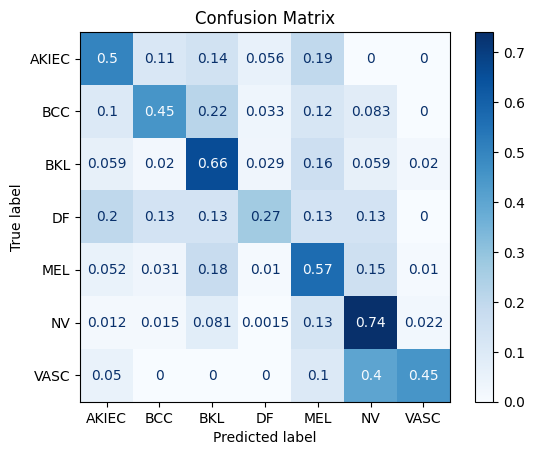

In [76]:
y_true = []
y_pred = []
for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(label_idx.keys())
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

In [78]:
# do accuracy basaed of y_pred and y_true
total_accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) * 100
print(f"Total Accuracy: {total_accuracy:.2f}%")

for i, cl in enumerate(label_idx.keys()):
    class_accuracy = cm[i][i] / np.sum(cm[i]) * 100
    class_precision = cm[i][i] / np.sum(cm[:, i]) * 100
    class_f1 = (
        2 * (class_accuracy * class_precision) / (class_accuracy + class_precision)
    )

    print(
        f"{cl} \tAccuracy: {class_accuracy:.2f}% | Precision: {class_precision:.2f}% | F1: {class_f1:.2f}%"
    )

Total Accuracy: 67.60%
AKIEC 	Accuracy: 50.00% | Precision: 51.42% | F1: 50.70%
BCC 	Accuracy: 45.00% | Precision: 59.22% | F1: 51.14%
BKL 	Accuracy: 65.69% | Precision: 46.86% | F1: 54.70%
DF 	Accuracy: 26.67% | Precision: 67.21% | F1: 38.18%
MEL 	Accuracy: 56.70% | Precision: 40.60% | F1: 47.32%
NV 	Accuracy: 74.03% | Precision: 47.14% | F1: 57.60%
VASC 	Accuracy: 45.00% | Precision: 89.59% | F1: 59.91%
